In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
from timeit import default_timer as timer

# Formation Python - *Quelques exemples*

## Ensembles de Julia

Soit $z_0$ un nombre complexe que l'on associe aux points du plan. Si un point a pour coordonnées $(x, y)$ alors $z_0=x + iy$ (où $i^2=-1$). Soit $c$ un autre nombre complexe constant. On définit une suite $z_n$ par la relation de récurrence

$$
z_{n+1} = z_n^2 + c.
$$

Alors l'ensemble de Julia est l'ensemble des points $z_0$ dont la suite des itérés reste bornée.

### Définition des paramètres pour nos tests

In [2]:
# taille de la grille
nx, ny = 1024, 1024
# limites indiquant quand la suite diverge
lim, maxit = 400, 2000
# valeurs à visualiser 
vmin, vmax = 0, 200
# définition de la grille
x = np.linspace(-1.6, 1.6, nx)
y = np.linspace(-1.6, 1.6, ny)
c = -0.772691322542185 + 0.124281466072787j

### Version Python pur

In [3]:
def juliasetPurePython(x, y, c, lim, maxit):
    """ 
    Renvoie l'ensemble de Julia
    
    Paramètres
    ----------
    x: coordonnées des parties réelles regardées
    y: coordonnées des parties imaginaires regardées
    c: nombre complexe figurant dans z^2 + c
    lim: limite du module complexe à partir de laquelle la suite est dite divergente
    maxit: nombre d'itérés maximal
    
    """
    julia = np.zeros((x.size, y.size))

    for i in range(x.size):
        for j in range(y.size):
            z = x[i] + 1j*y[j]
            ite = 0
            while abs(z) < lim and ite < maxit:
                z = z**2 + c
                ite += 1
            julia[j, i] = ite

    return julia

In [4]:
julia1 = juliasetPurePython(x, y, c, lim, maxit)

### Fonction permettant de récupérer l'ensemble des temps d'exécution

In [5]:
def myTimer(fonction, fonction_args=(), nrep=10):
    t = timer()
    for i in range(nrep):
        fonction(*fonction_args)
    try:
        name = fonction.__name__
    except:
        name = fonction.py_func.func_name
    return [name, (timer() - t)/nrep]

In [6]:
import copy
from pandas import DataFrame

def printTable(execTime):
    t = np.zeros(len(execTime))
    cdata = copy.deepcopy(execTime)

    for i in range(len(cdata)):
        t[i] = cdata[i][1]
        
    mx = np.max(t)
    for d in cdata:
        d.append(mx/d[1])

    df = DataFrame(data = cdata, columns=['Nom des fonctions', "Temps d'exécution", "Rapport"])
    return df

### Représentation de l'ensemble de Julia

In [7]:
def plotJuliaSet(julia):
    plt.figure(figsize=(10,10))
    plt.imshow(julia, cmap = cm.Greys, vmin=vmin, vmax=vmax)

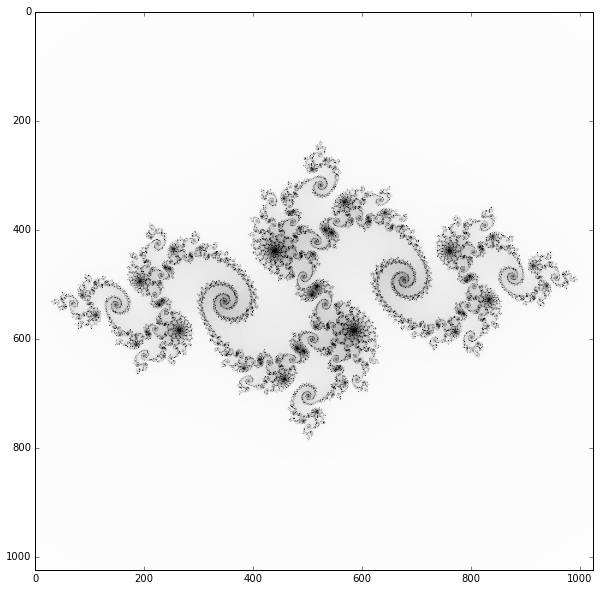

In [8]:
plotJuliaSet(julia1)

### Version Numpy

Dans cette version, on essaie de vectoriser au maximum. Le coût ici est que l'on fait plus d'opérations que dans le cas Python pur. On ne gagne donc pas forcément beaucoup de temps comme on le verra par la suite.

In [9]:
def juliasetNumpy(x, y, c, lim, maxit):
    julia = np.zeros((x.size, y.size), dtype=np.int32)

    zx = x
    zy = y[:, np.newaxis]
    
    z = zx + zy*1j
    
    ite = 0
    while not np.all(julia) and ite < maxit:
        z = z**2 + c
        mask = np.logical_not(julia) & (np.abs(z) >= lim)
        ite += 1
        julia[mask] = ite

    return julia

On calcule les temps d'exécution pour les versions Python pur et Numpy et on constate que l'on n'a pas gagné grand chose.

In [10]:
execution_times = []
execution_times.append(myTimer(juliasetPurePython, (x, y, c, lim, maxit), 1))
execution_times.append(myTimer(juliasetNumpy, (x, y, c, lim, maxit), 1))

In [11]:
printTable(execution_times)

,Nom des fonctions,Temps d'exécution,Rapport
0,juliasetPurePython,18.429719,1.000000
1,juliasetNumpy,17.966841,1.025763


## Modèle de Gray-Scott

Le modèle de Gray-Scott permet de simuler deux espèces chimiques $A$ et $B$ qui réagissent entre elles et qui diffusent.

Le modèle mathématique est assez simple

$$
\begin{array}{l}
\frac{\partial A}{\partial t} = D_A \Delta A - AB^2 + f(1-A) \\
\frac{\partial B}{\partial t} = D_B \Delta B + AB^2 - (k+f)B
\end{array}
$$

On peut approcher le laplacien par un schéma aux différences finies à 5 points. 

$$
\Delta A_{i,j} \approx A_{i,j-1} + A_{i-1,j} -4A_{i,j} + A_{i+1, j} + A_{i, j+1}
$$

La dérivée en temps peut être approchée par un schéma d'Euler explicite.

### Initialisation

$A$ vaut $1$ partout et $B$ vaut $0$ partout sauf à un endroit du domaine où on met $0.25$. Cet endroit sera une ellipse centrée au centre du domaine $[0, 1]\times[0,1]$et de rayons $r_x=0.01$ et $r_y=0.02$.

In [3]:
def init(n):
    A = np.ones((n+2,n+2))
    B = np.zeros((n+2,n+2))

    x = np.linspace(0, 1, n+2)
    y = np.linspace(0, 1, n+2)[:, np.newaxis]

    rx = .02
    ry = .04

    mask = (x-.5)**2/rx**2 + (y-.5)**2/ry**2 < 1
    B[mask] = .25
    return A, B

### Conditions périodiques

In [4]:
def periodic_cond(u):
    u[0, :] = u[-2, :]
    u[-1, :] = u[1, :]
    u[:, 0] = u[:, -2]
    u[:, -1] = u[:, 1]

### Laplacien et modèle de Gray-Scott

In [5]:
def laplacian(u):
  return (                  u[ :-2, 1:-1] +
           u[1:-1, :-2] - 4*u[1:-1, 1:-1] + u[1:-1, 2:] +
                        +   u[2:  , 1:-1] )

def grayscott(A, B, Da, Db, f, k):
    a, b = A[1:-1,1:-1], B[1:-1,1:-1]

    La = laplacian(A)
    Lb = laplacian(B)

    abb = a*b*b
    a += Da*La - abb + f*(1 - a)
    b += Db*Lb + abb - (f + k)*b

    periodic_cond(A)
    periodic_cond(B)

In [19]:
def animate(i):
  global A, B, Da, Da; f, k
  for t in range(40):
    grayscott(A, B, Da, Db, f, k)
  im.set_array(B)
  return im,

In [20]:
Da, Db = .1, .05
f, k = 0.0367, 0.0649 
#f, k = 0.0545, 0.062
#f, k = 0.018, 0.050
#f, k = 0.050, 0.065
#f, k = 0.035, 0.060

<IPython.core.display.Javascript object>


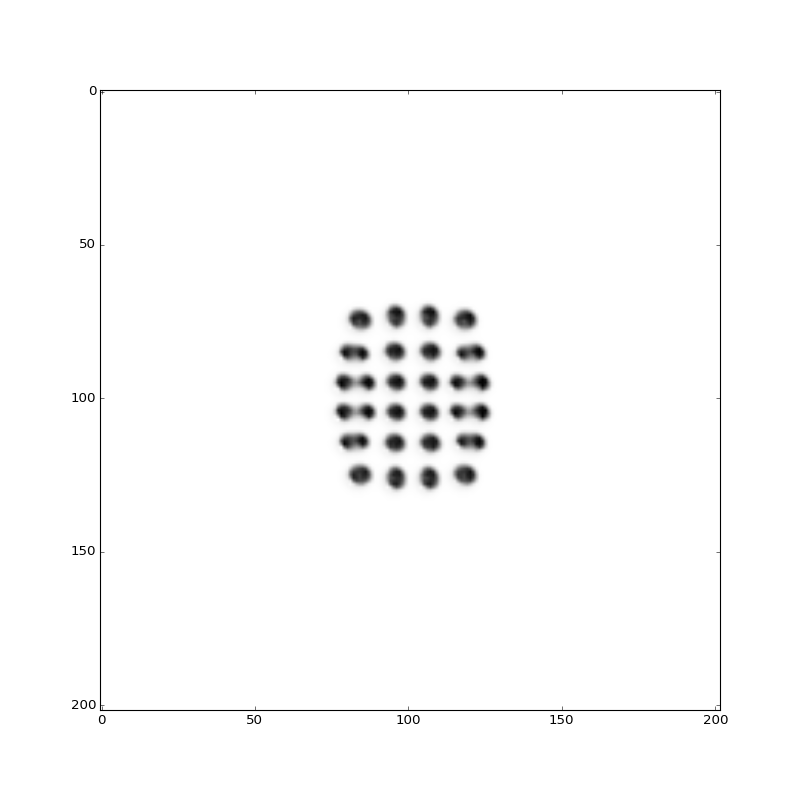

In [21]:
%matplotlib nbagg

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

A, B = init(200)

im = plt.imshow(B, cmap = cm.Greys)

anim = animation.FuncAnimation(fig, animate, np.arange(1, 200),
    interval=2, blit=True)

plt.show()

In [ ]:
# execute this part to modify the css style
from IPython.core.display import HTML
def css_styling():
    styles = open("../../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()